ValueError: too many values to unpack (expected 3)

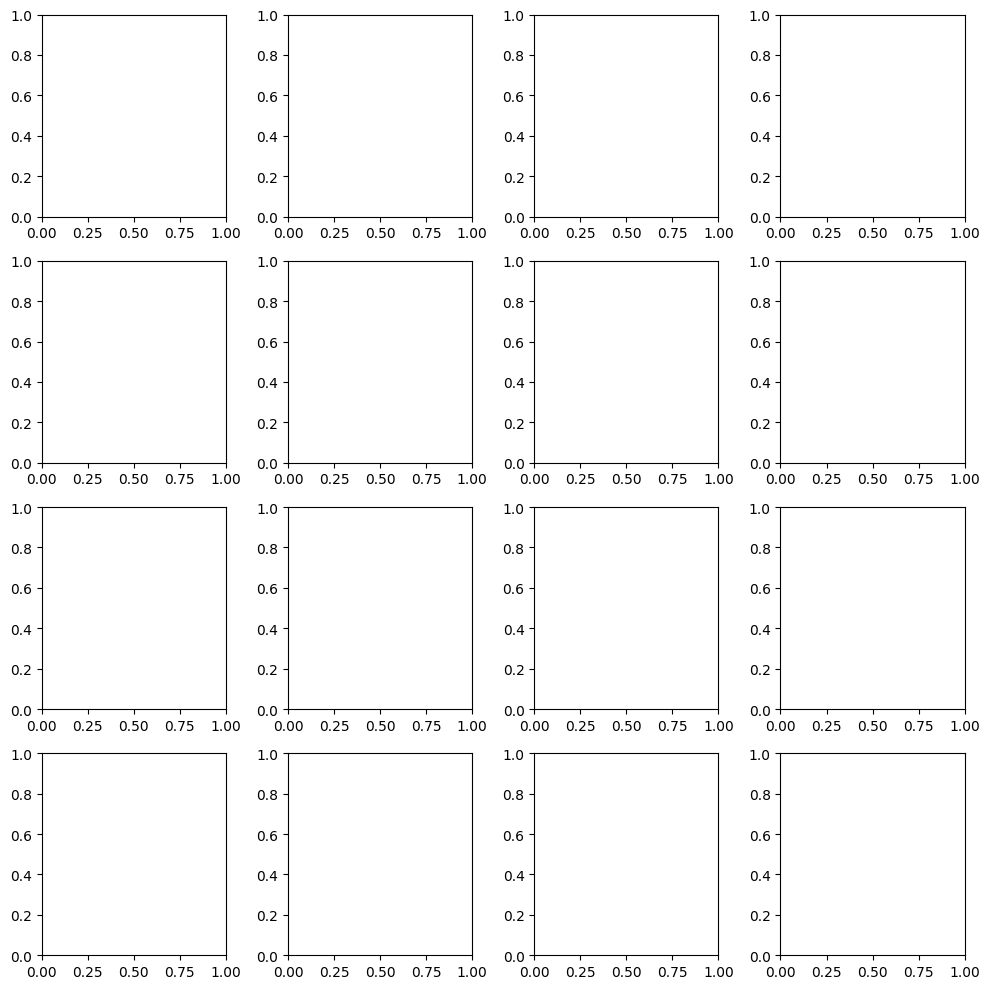

In [1]:
import torch
from torch.utils.data import DataLoader
from datasets.clock import ClockConfig, ClockDataset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 128
BATCH_SIZE = 64
data_size = 4096

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False, config=data_config)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# visualize 16 images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
batch, labels2d, _ = next(iter(dataloader))
for i in range(16):
    img = batch[i].unsqueeze(0)
    label = labels2d[i].numpy()
    hour = label[0] * 12
    minute = label[1] * 60
    axs[i // 4, i % 4].imshow(img[0].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
    axs[i // 4, i % 4].axis('off')


# plt.show()

In [5]:
from models.encoders import TwoHeadConvEncoder, ConvSelfAttentionEncoder, ConvResEncoder, DeepConvResEncoder, WideConvResEncoder
from models.decoders import ResNetDecoder
import torch

torch.cuda.empty_cache()

model = ResNetDecoder(img_size=IMG_SIZE, latent_dim=2, device=device).to(device)
img, labels2d, _ = next(iter(dataloader))
labels2d = labels2d.to(device)
img = img.to(device)

y = model(labels2d)
# y = model(img)
y.shape

# out = y.view(BATCH_SIZE, IMG_SIZE, IMG_SIZE, -1).permute(0, 3, 1, 2)  # Reshape to (B, C, H, W)
# out.shape

torch.Size([64, 1, 128, 128])

In [ ]:
from models.encoders import DeepConvResEncoder, MLPEncoderReLU, TwoHeadConvEncoder, ConvResEncoder, WideConvResEncoder
from torch import nn

cls = MLPEncoderReLU

ae = cls(img_size=128, latent_dim=2)

def print_model_parameters(model: nn.Module):
    print(f"{'Layer':<40}{'Param Count':>15}")
    print("-" * 60)
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40}{param_count:>15}")
    
    print("-" * 60)
    print(f"{'Total Trainable Parameters':<40}{total_params:>15}")

# count params
print_model_parameters(ae)


ImportError: cannot import name 'MLPEncoder' from 'models.encoders' (/mnt/ffs24/home/moham147/experiments/manifold-learning/models/encoders.py)

# Checkpoints

In [5]:
import os
from datasets.clock import ClockDataset, ClockConfig
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR

MODELS_DIR = 'models'
LATENT_DIM = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_and_dataset(
    img_size=128,
    batch_size=64,
    data_size=2048,
    latent_dim=2,
    postfix='',
    name='model',
    data_config=None,
    checkpoint=None
):
    """
    Load the model and dataset for inference.
    """
    # Load dataset
    dataset = ClockDataset(len=data_size, img_size=img_size, augment=False, config=data_config)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Load trained model
    model_file = f"{latent_dim}-i{img_size}{postfix}"
    
    if checkpoint is not None:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"final.pt")
    else:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"{checkpoint}.pt")
    
    model = torch.jit.load(model_path).to(device)
    
    return model, dataloader

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

In [9]:
import torch
from config import MODELS_DIR
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_device('cpu')

def get_outputs(
  img_size, name, postfix, checkpoint
): 

  model, dataloader = load_model_and_dataset(
      img_size=img_size,
      data_config=data_config,
      latent_dim=LATENT_DIM,
      name=name,
      postfix=postfix,
      checkpoint=checkpoint
  )

  imgs = []
  labels1d = []
  labels2d = []
  predicted_labels2d = []

  with torch.no_grad():
    for images, images_clean, label2d, label1d in dataloader:
      images_clean = images_clean.to(device)
      out = model.forward(images_clean).cpu()
      
      label2d = (label2d * torch.tensor([12, 60]).float())
      predicted_label2d = (out * torch.tensor([12, 60]).float())
      
      imgs.append(images_clean.cpu().numpy())
      labels1d.append(label1d.numpy())
      labels2d.append(label2d.numpy())
      predicted_labels2d.append(predicted_label2d)
      

  predicted_labels2d = np.concatenate(predicted_labels2d, axis=0)
  labels1d = np.concatenate(labels1d, axis=0)  # Denormalize to minutes past midnight
  labels2d = np.concatenate(labels2d, axis=0)
  imgs = np.concatenate(imgs, axis=0)

  return imgs, labels1d, labels2d, predicted_labels2d


imgs, labels1d, labels2d, predicted_labels2d = get_outputs(
    img_size=128,
    name='MLPEncoderSigmoid',
    postfix='-d21',
    checkpoint=7
)


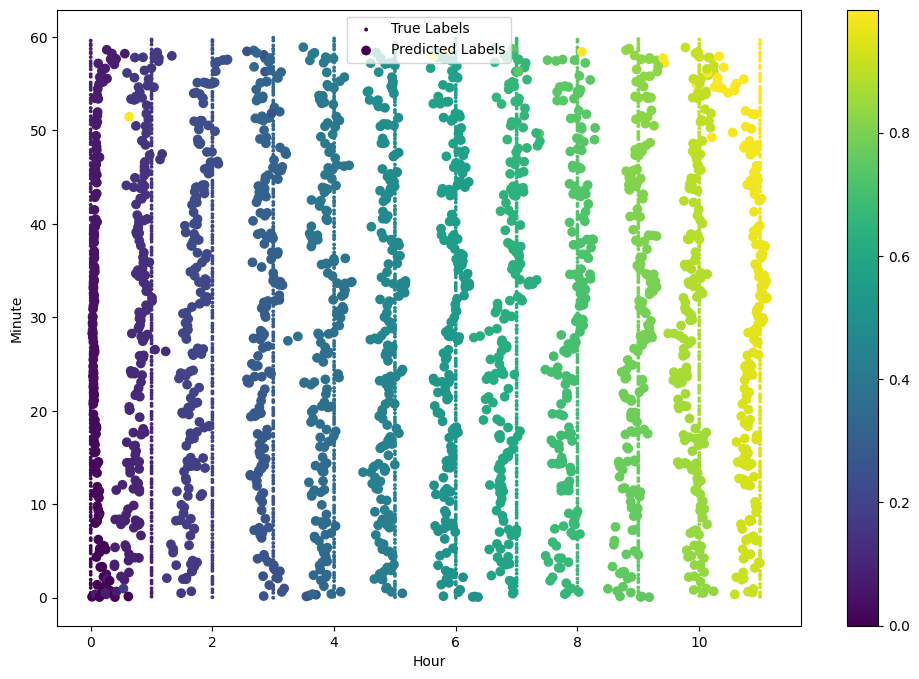

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(labels2d[:, 0], labels2d[:, 1], c=labels1d, label='True Labels', s=3)
plt.scatter(predicted_labels2d[:, 0], predicted_labels2d[:, 1], c=labels1d, label='Predicted Labels')
plt.colorbar()
plt.xlabel('Hour')
plt.ylabel('Minute')
plt.legend()

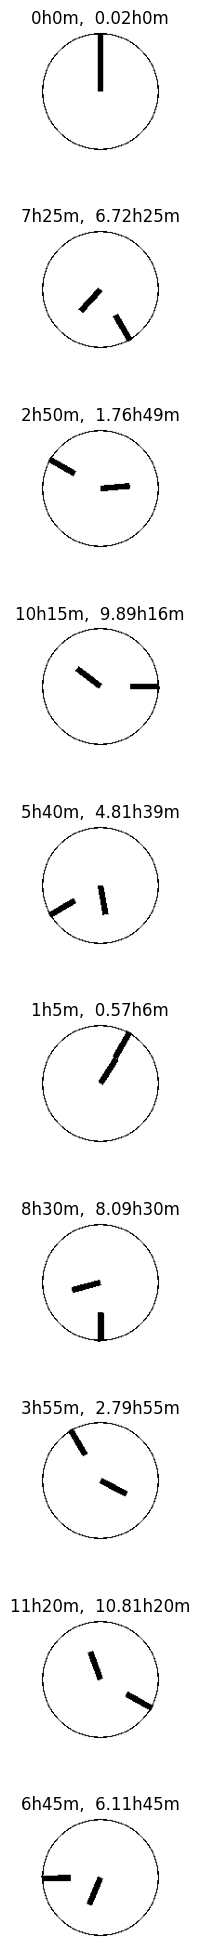

In [18]:
# Visualize the predictions
n=10
fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
fig.tight_layout()

for i in range(n):
  img = imgs[i].squeeze()
  label = labels2d[i]
  predicted_label = predicted_labels2d[i]
  
  axs[i].imshow(img, cmap='gray')
  axs[i].set_title(f"{label[0]:.0f}h{label[1]:.0f}m,  {predicted_label[0]:.2f}h{predicted_label[1]:.0f}m")
  axs[i].axis('off')
